# Instacart 2017

## TASK: 
#### Given a user, a product, and the user's prior purchase history, predict whether or not the given product will be reordered in the user's next order

##### orders (3.4m rows, 206k users):

order_id: order identifier

user_id: customer identifier

eval_set: which evaluation set this order belongs in (see SET described below)

order_number: the order sequence number for this user (1 = first, n = nth)

order_dow: the day of the week the order was placed on

order_hour_of_day: the hour of the day the order was placed on

days_since_prior: days since the last order, capped at 30


##### products (50k rows):

product_id: product identifier

product_name: name of the product

aisle_id: foreign key

department_id: foreign key


##### aisles (134 rows):

aisle_id: aisle identifier

aisle: the name of the aisle


##### deptartments (21 rows):

department_id: department identifier

department: the name of the department


##### order_products__SET (30m+ rows):

order_id: foreign key

product_id: foreign key

add_to_cart_order: order in which each product was added to cart

reordered: 1 if this product has been ordered by this user in the past, 0 otherwise


###### where SET is one of the four following evaluation sets (eval_set in orders):

"prior": orders prior to that users most recent order (~3.2m orders)

"train": training data supplied to participants (~131k orders)

"test": test data reserved for machine learning competitions (~75k orders)

## Modules

In [1]:
import psycopg2
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Data Wrangling

In [3]:
conn = psycopg2.connect(dbname="Instacart_market", user="postgres", password="3102", host='localhost')
schema=pd.read_sql("""SELECT table_catalog, table_schema, table_name, table_type 
                      FROM information_schema.tables 
                      WHERE table_schema='public'""", conn)
conn.close()

In [71]:
conn = psycopg2.connect(dbname="Instacart_market", user="postgres", password="3102", host='localhost')
orders=pd.read_sql("""SELECT *,SUM(days_since_prior) OVER (PARTITION BY user_id ORDER BY order_number) FROM orders LIMIT 10000""", conn)
conn.close()

In [72]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior,sum
0,2539329.0,1.0,prior,1.0,2.0,8.0,NaN,NaN
1,2398795.0,1.0,prior,2.0,3.0,7.0,15.0,15.0
2,473747.0,1.0,prior,3.0,3.0,12.0,21.0,36.0
3,2254736.0,1.0,prior,4.0,4.0,7.0,29.0,65.0
4,431534.0,1.0,prior,5.0,4.0,15.0,28.0,93.0


In [73]:
orders.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior,sum
count,1.000000e+04,10000.000000,10000.00000,10000.000000,10000.00000,9367.000000,9367.000000
mean,1.712365e+06,312.853600,16.37840,2.765100,13.44390,11.235508,126.285043
std,9.886568e+05,177.348206,17.36391,2.029417,4.19092,9.209374,90.592420
min,4.000000e+01,1.000000,1.00000,0.000000,0.00000,0.000000,0.000000
25%,8.760425e+05,163.000000,4.00000,1.000000,10.00000,4.000000,51.000000
50%,1.694660e+06,309.000000,10.00000,3.000000,13.00000,8.000000,107.000000
75%,2.569635e+06,462.000000,22.00000,5.000000,16.00000,15.000000,188.000000
max,3.420572e+06,633.000000,100.00000,6.000000,23.00000,30.000000,365.000000


In [6]:
query01=""" SELECT  *
            FROM products 
            JOIN aisles 
            USING (aisle_id) 
            JOIN departments 
            USING (department_id)
            LIMIT 1000"""

conn = psycopg2.connect(dbname="Instacart_market", user="postgres", password="3102", host='localhost')
products=pd.read_sql(query01, conn)
conn.close()

In [7]:
products

,department_id,aisle_id,product_id,product_name,aisle,department
0,7.0,94.0,3.0,Robust Golden Unsweetened Oolong Tea,tea,beverages
1,1.0,38.0,4.0,Smart Ones Classic Favorites Mini Rigatoni Wit...,frozen meals,frozen
2,13.0,5.0,5.0,Green Chile Anytime Sauce,marinades meat preparation,pantry
3,11.0,11.0,6.0,Dry Nose Oil,cold flu allergy,personal care
4,7.0,98.0,7.0,Pure Coconut Water With Orange,juice nectars,beverages
5,1.0,116.0,8.0,Cut Russet Potatoes Steam N' Mash,frozen produce,frozen
6,16.0,120.0,9.0,Light Strawberry Blueberry Yogurt,yogurt,dairy eggs
7,7.0,115.0,10.0,Sparkling Orange Juice & Prickly Pear Beverage,water seltzer sparkling water,beverages
8,7.0,31.0,11.0,Peach Mango Juice,refrigerated,beverages
9,1.0,119.0,12.0,Chocolate Fudge Layer Cake,frozen dessert,frozen


#### Aisles in each department

In [8]:
query02="""WITH t1 AS  (SELECT  *
                        FROM products 
                        JOIN aisles 
                        USING (aisle_id) 
                        JOIN departments 
                        USING (department_id)
                        LIMIT 1000)
            
            SELECT department,COUNT(DISTINCT aisle)
            FROM t1
            GROUP BY department"""

conn = psycopg2.connect(dbname="Instacart_market", user="postgres", password="3102", host='localhost')
departmnet_aisle=pd.read_sql(query02, conn)
conn.close()


In [9]:
departmnet_aisle

,department,count
0,alcohol,5
1,babies,4
2,bakery,5
3,beverages,8
4,breakfast,4
5,bulk,2
6,canned goods,5
7,dairy eggs,8
8,deli,5
9,dry goods pasta,5


In [10]:
conn = psycopg2.connect(dbname="Instacart_market", user="postgres", password="3102", host='localhost')
departments=pd.read_sql("SELECT * FROM departments", conn)
conn.close()

In [11]:
departments.head()

,department_id,department
0,1.0,frozen
1,2.0,other
2,3.0,bakery
3,4.0,produce
4,5.0,alcohol


In [11]:
conn = psycopg2.connect(dbname="Instacart_market", user="postgres", password="3102", host='localhost')
aisles=pd.read_sql("SELECT * FROM aisles", conn)
conn.close()

In [12]:
aisles.head()

,aisle_id,aisle
0,1.0,prepared soups salads
1,2.0,specialty cheeses
2,3.0,energy granola bars
3,4.0,instant foods
4,5.0,marinades meat preparation


In [4]:
conn = psycopg2.connect(dbname="Instacart_market", user="postgres", password="3102", host='localhost')
order_products_prior=pd.read_sql("""SELECT * FROM order_products_prior LIMIT 1000""", conn)
conn.close()

In [14]:
order_products_prior

,order_id,product_id,add_to_cart_order,reordered
0,2.0,33120.0,1.0,1.0
1,2.0,28985.0,2.0,1.0
2,2.0,9327.0,3.0,0.0
3,2.0,45918.0,4.0,1.0
4,2.0,30035.0,5.0,0.0
5,2.0,17794.0,6.0,1.0
6,2.0,40141.0,7.0,1.0
7,2.0,1819.0,8.0,1.0
8,2.0,43668.0,9.0,0.0
9,3.0,33754.0,1.0,1.0


In [15]:
conn = psycopg2.connect(dbname="Instacart_market", user="postgres", password="3102", host='localhost')
order_products_train=pd.read_sql("""SELECT * FROM order_products_train LIMIT 10""", conn)
conn.close()

In [16]:
order_products_train

,order_id,product_id,add_to_cart_order,reordered
0,1.0,49302.0,1.0,1.0
1,1.0,11109.0,2.0,1.0
2,1.0,10246.0,3.0,0.0
3,1.0,49683.0,4.0,0.0
4,1.0,43633.0,5.0,1.0
5,1.0,13176.0,6.0,0.0
6,1.0,47209.0,7.0,0.0
7,1.0,22035.0,8.0,1.0
8,36.0,39612.0,1.0,0.0
9,36.0,19660.0,2.0,1.0


In [145]:
query03="""SELECT  user_id, order_id, department, aisle,product_name, order_number, add_to_cart_order, reordered,
          order_dow, order_hour_of_day, days_since_prior
          FROM order_products_prior 
          JOIN orders 
          USING (order_id) 
          JOIN products 
          USING (product_id) 
          JOIN departments
          USING (department_id)
          JOIN aisles
          USING (aisle_id)
          ORDER BY user_id
          LIMIT 10000"""

conn = psycopg2.connect(dbname="Instacart_market", user="postgres", password="3102", host='localhost')
aggregated_prior=pd.read_sql(query03, conn)
conn.close()

In [146]:
aggregated_prior.head(30)

,user_id,order_id,department,aisle,product_name,order_number,add_to_cart_order,reordered,order_dow,order_hour_of_day,days_since_prior
0,1.0,3108588.0,snacks,nuts seeds dried fruit,Pistachios,8.0,3.0,1.0,1.0,14.0,14.0
1,1.0,2254736.0,snacks,nuts seeds dried fruit,Pistachios,4.0,3.0,1.0,4.0,7.0,29.0
2,1.0,550135.0,snacks,nuts seeds dried fruit,Pistachios,7.0,2.0,1.0,1.0,9.0,20.0
3,1.0,2254736.0,dairy eggs,packaged cheese,Organic String Cheese,4.0,4.0,1.0,4.0,7.0,29.0
4,1.0,2550362.0,beverages,soft drinks,Zero Calorie Cola,10.0,2.0,1.0,4.0,8.0,30.0
5,1.0,3367565.0,snacks,nuts seeds dried fruit,Pistachios,6.0,3.0,1.0,2.0,7.0,19.0
6,1.0,2398795.0,breakfast,cereal,Cinnamon Toast Crunch,2.0,6.0,0.0,3.0,7.0,15.0
7,1.0,2295261.0,snacks,nuts seeds dried fruit,Pistachios,9.0,5.0,1.0,1.0,16.0,0.0
8,1.0,431534.0,produce,fresh fruits,Organic Fuji Apples,5.0,5.0,0.0,4.0,15.0,28.0
9,1.0,2398795.0,snacks,popcorn jerky,Original Beef Jerky,2.0,3.0,1.0,3.0,7.0,15.0


In [147]:
aggregated_prior.describe()

,user_id,order_id,order_number,add_to_cart_order,reordered,order_dow,order_hour_of_day,days_since_prior
count,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,9265.000000
mean,40.575000,1.697551e+06,14.614400,7.527300,0.532100,2.816200,12.789300,12.518618
std,20.932802,9.666198e+05,17.119171,6.269799,0.498993,2.004799,3.726566,9.134898
min,1.000000,4.595000e+03,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,8.647200e+05,4.000000,3.000000,0.000000,1.000000,10.000000,6.000000
50%,39.000000,1.681401e+06,8.000000,6.000000,1.000000,3.000000,12.000000,9.000000
75%,58.000000,2.550362e+06,17.000000,10.000000,1.000000,5.000000,15.000000,18.000000
max,77.000000,3.408319e+06,81.000000,46.000000,1.000000,6.000000,23.000000,30.000000


### Checking for null values

In [20]:
conn = psycopg2.connect(dbname="Instacart_market", user="postgres", password="3102", host='localhost')
null_values=pd.read_sql("""SELECT * FROM orders t WHERE NOT(t IS NOT NULL)""", conn)
conn.close()

In [21]:
null_values.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior
0,2539329.0,1.0,prior,1.0,2.0,8.0,None
1,2168274.0,2.0,prior,1.0,2.0,11.0,None
2,1374495.0,3.0,prior,1.0,1.0,14.0,None
3,3343014.0,4.0,prior,1.0,6.0,11.0,None
4,2717275.0,5.0,prior,1.0,3.0,12.0,None


There is a null value for each user in the days_since_prior column for order_number = 1

## Exploring the data

### What day of week most orders were made?

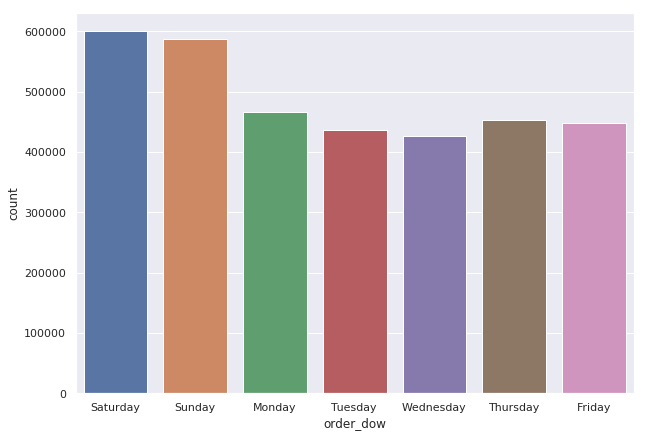

In [42]:
fig1=plt.figure(figsize=(10,7))
sns.countplot(x=orders['order_dow']).set_xticklabels([ "Saturday", "Sunday","Monday","Tuesday","Wednesday","Thursday", "Friday"])
plt.show()
plt.close()


### What hour of day most orders were made?

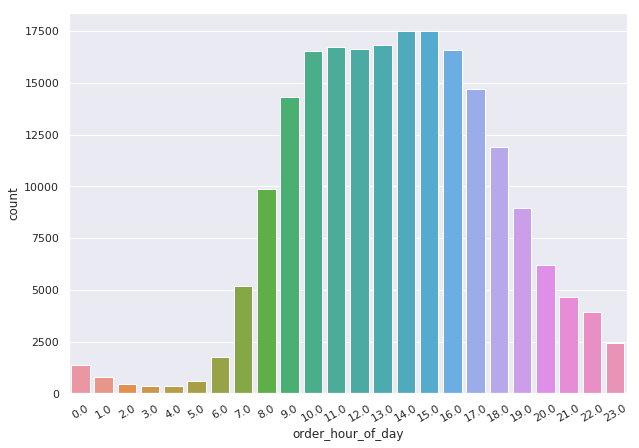

In [26]:
fig2=plt.figure(figsize=(10,7))
sns.countplot(x=orders['order_hour_of_day'])
plt.xticks(rotation=30)
plt.show()
plt.close()


### How many days have passed since the previous order?

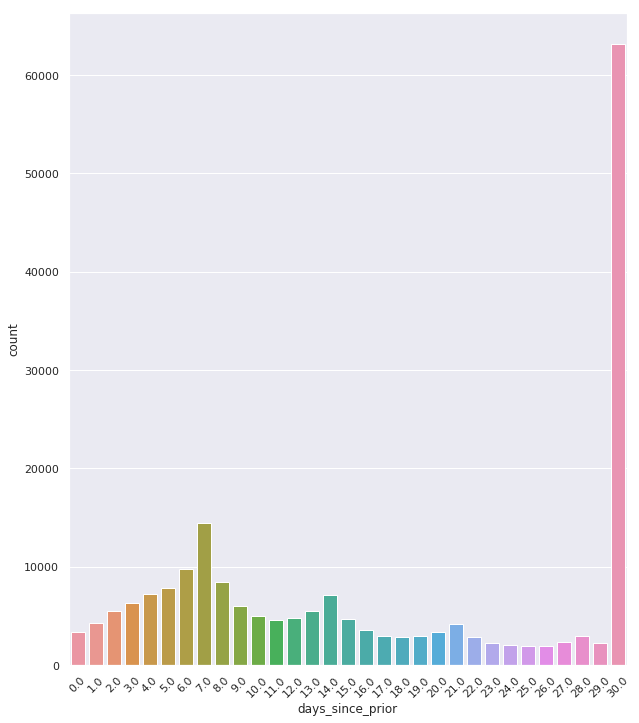

In [27]:
fig3=plt.figure(figsize=(10,12))
b=sns.countplot(x=orders['days_since_prior'])
b.set_xticklabels(b.get_xticklabels(),rotation=45)

plt.show()
plt.close()


### How many users ordered at least 'n' times?

In [4]:
conn = psycopg2.connect(dbname="Instacart_market", user="postgres", password="3102", host='localhost')
orders1=pd.read_sql("""SELECT order_number n,COUNT(*)  FROM Orders WHERE eval_set='prior' GROUP BY order_number """, conn)
conn.close()

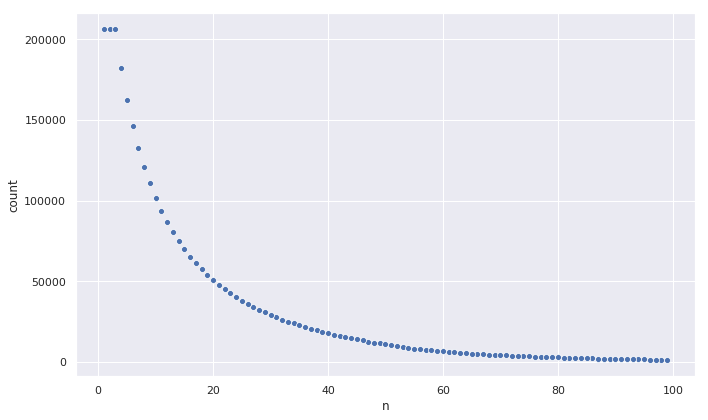

In [28]:
fig5=plt.figure(figsize=(10,6))
sns.scatterplot(x='n',y='count',data=orders1)
plt.tight_layout()
plt.show()
plt.close()


### How many products are there in each department?

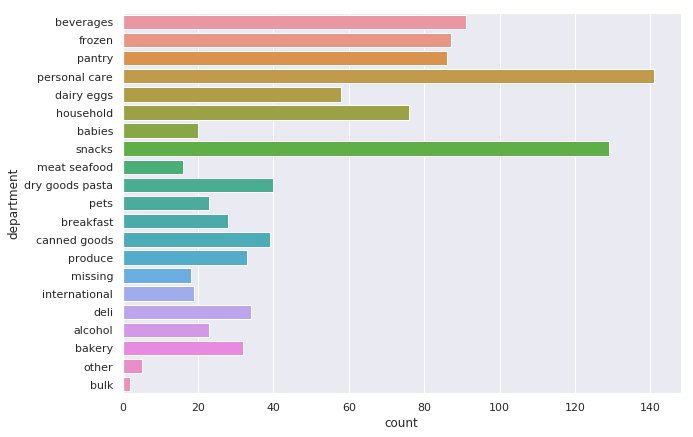

In [76]:
plt.figure(figsize=(10,7))
sns.countplot(y=products['department'])
plt.show()
plt.close()


### How many users bought at least 'n' products?

In [52]:
query06="""SELECT COUNT(*) ,max AS n
           FROM (SELECT MAX(add_to_cart_order)
                 FROM order_products_prior
                 GROUP BY order_id) t4
           GROUP BY max"""


conn = psycopg2.connect(dbname="Instacart_market", user="postgres", password="3102", host='localhost')
order_products_prior=pd.read_sql(query06, conn)
conn.close()


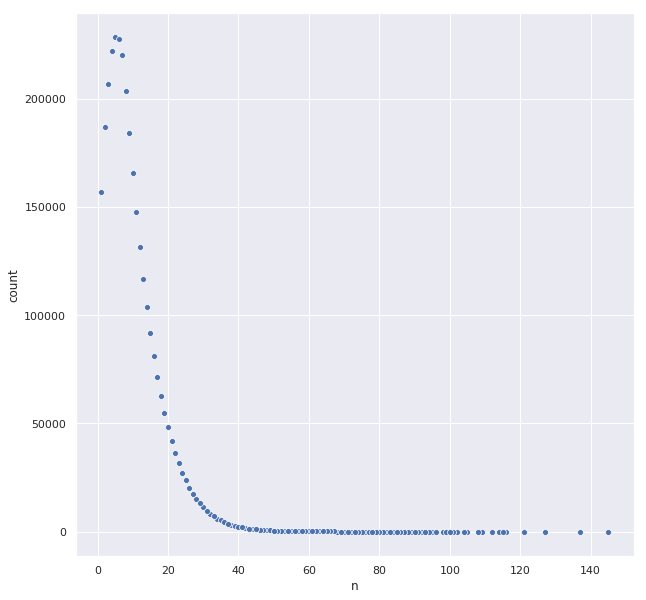

In [54]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='n',y='count',data=order_products_prior)
plt.show()


### Ηow many products users buy during the day?

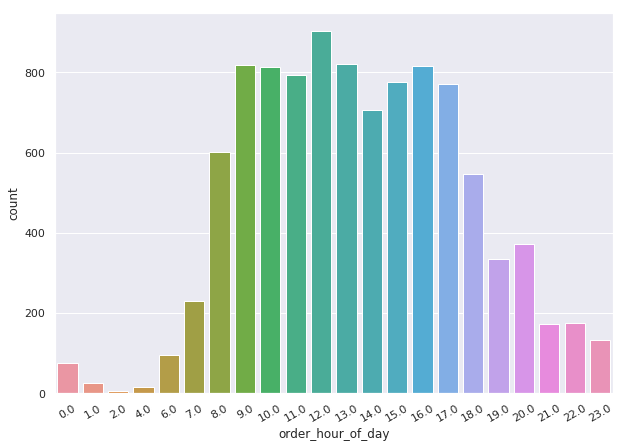

In [60]:
plt.figure(figsize=(10,7))
sns.countplot(x=aggregated_prior['order_hour_of_day'])
plt.xticks(rotation=30)
plt.show()
plt.close()


### Ηow many products users buy during the week?

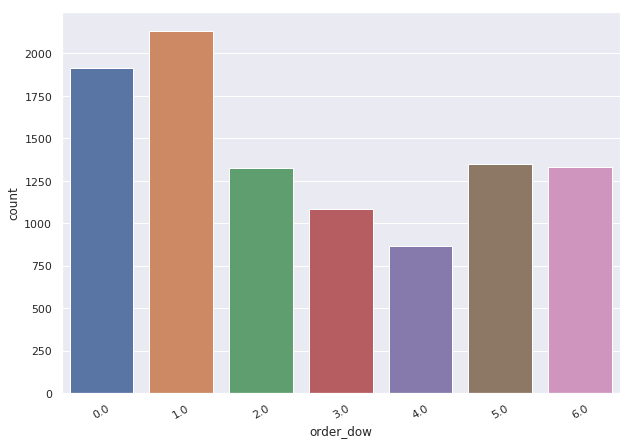

In [61]:
plt.figure(figsize=(10,7))
sns.countplot(x=aggregated_prior['order_dow'])
plt.xticks(rotation=30)
plt.show()
plt.close()


### How many products did purchased ? (for all records)

In [3]:
query07="""WITH aggregated_prior AS (SELECT  user_id, order_id, department, aisle,product_name, order_number, add_to_cart_order, reordered,
                                          order_dow, order_hour_of_day, days_since_prior
                                          FROM order_products_prior 
                                          JOIN orders 
                                          USING (order_id) 
                                          JOIN products 
                                          USING (product_id) 
                                          JOIN departments
                                          USING (department_id)
                                          JOIN aisles
                                          USING (aisle_id)
                                          LIMIT 1000)



                  SELECT product_name,aisle,department,COUNT(*)
                  FROM aggregated_prior
                  GROUP BY 1,2,3
                  ORDER BY 4 DESC
                  LIMIT 10"""




conn = psycopg2.connect(dbname="Instacart_market", user="postgres", password="3102", host='localhost')
best_products1=pd.read_sql(query07, conn)
conn.close()
          

In [4]:
best_products1

,product_name,aisle,department,count
0,Bag of Organic Bananas,fresh fruits,produce,12
1,Banana,fresh fruits,produce,11
2,Organic Baby Spinach,packaged vegetables fruits,produce,8
3,Organic Avocado,fresh fruits,produce,8
4,Organic Hass Avocado,fresh fruits,produce,7
5,Organic Strawberries,fresh fruits,produce,6
6,Large Lemon,fresh fruits,produce,5
7,Organic Lemon,fresh fruits,produce,5
8,Strawberries,fresh fruits,produce,5
9,Organic Raspberries,packaged vegetables fruits,produce,5


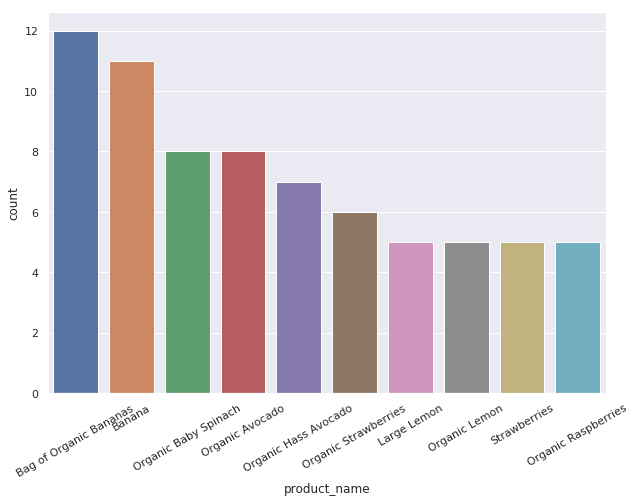

In [5]:
plt.figure(figsize=(10,7))
sns.barplot(x='product_name',y='count',data=best_products1)
plt.xticks(rotation=30)
plt.show()
plt.close()

### How many products did purchased ? (for all users)

In [13]:
query07="""WITH aggregated_prior AS (SELECT  user_id, order_id, department, aisle,product_name, order_number, add_to_cart_order, reordered,
                                          order_dow, order_hour_of_day, days_since_prior
                                          FROM order_products_prior 
                                          JOIN orders 
                                          USING (order_id) 
                                          JOIN products 
                                          USING (product_id) 
                                          JOIN departments
                                          USING (department_id)
                                          JOIN aisles
                                          USING (aisle_id)
                                          LIMIT 1000)


SELECT product_name,COUNT(*)
FROM (SELECT product_name,user_id,COUNT(*)
      FROM aggregated_prior
      GROUP BY 1,2) fff
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10"""




conn = psycopg2.connect(dbname="Instacart_market", user="postgres", password="3102", host='localhost')
best_products2=pd.read_sql(query07, conn)
conn.close()
          

In [14]:
best_products2

,product_name,count
0,Bag of Organic Bananas,12
1,Banana,11
2,Organic Baby Spinach,8
3,Organic Avocado,8
4,Organic Hass Avocado,7
5,Organic Strawberries,6
6,Strawberries,5
7,Organic Lemon,5
8,Organic Raspberries,5
9,Large Lemon,5


### Which are the most popular aisles?

In [21]:
query07="""WITH aggregated_prior AS (SELECT  user_id, order_id, department, aisle,product_name, order_number, add_to_cart_order, reordered,
                                          order_dow, order_hour_of_day, days_since_prior
                                          FROM order_products_prior 
                                          JOIN orders 
                                          USING (order_id) 
                                          JOIN products 
                                          USING (product_id) 
                                          JOIN departments
                                          USING (department_id)
                                          JOIN aisles
                                          USING (aisle_id)
                                          LIMIT 10000)



                  SELECT aisle,department,COUNT(*)
                  FROM aggregated_prior
                  GROUP BY 1,2
                  ORDER BY 3 DESC
                  LIMIT 10"""




conn = psycopg2.connect(dbname="Instacart_market", user="postgres", password="3102", host='localhost')
best_aisles=pd.read_sql(query07, conn)
conn.close()
          

In [22]:
best_aisles.head()

,aisle,department,count
0,fresh fruits,produce,1128
1,fresh vegetables,produce,1076
2,packaged vegetables fruits,produce,513
3,yogurt,dairy eggs,395
4,packaged cheese,dairy eggs,313


### Other features

In [13]:
query="""WITH Y AS (SELECT *,SUM(days_since_prior) OVER (PARTITION BY user_id ORDER BY order_number) 
                    FROM orders 
                    LIMIT 1000)
                    
                    
                    
          SELECT user_id,CASE WHEN sum<32 OR sum IS NULL THEN '1st'
                              WHEN sum BETWEEN 32 AND 60 THEN '2nd'
                              WHEN sum BETWEEN 61 AND 92  THEN '3rd'
                              WHEN sum BETWEEN 93 AND 123 THEN '4th'
                              WHEN sum BETWEEN 124 AND 155 THEN '5th'
                              WHEN sum BETWEEN 156 AND 188 THEN '6th'
                              WHEN sum BETWEEN 189 AND 220 THEN '7th'
                              WHEN sum BETWEEN 221 AND 252 THEN '8th'
                              WHEN sum BETWEEN 253 AND 283 THEN '9th'
                              WHEN sum BETWEEN 284 AND 315 THEN '10th'
                              WHEN sum BETWEEN 316 AND 346 THEN '11th'
                              ELSE '12th' END AS month,COUNT(*)
           FROM Y                    
          GROUP BY 1,2
          ORDER BY user_id"""








conn = psycopg2.connect(dbname="Instacart_market", user="postgres", password="3102", host='localhost')
orders23=pd.read_sql(query, conn)
conn.close()

In [14]:
orders23

,user_id,month,count
0,1.0,4th,2
1,1.0,1st,2
2,1.0,6th,1
3,1.0,7th,1
4,1.0,2nd,1
5,1.0,5th,3
6,1.0,3rd,1
7,2.0,4th,1
8,2.0,3rd,2
9,2.0,6th,1


In [5]:
query061="""SELECT user_id, order_dow,COUNT(*)
            FROM orders
            GROUP BY user_id, order_dow
            ORDER BY 1
            LIMIT 1000"""
        
            


conn = psycopg2.connect(dbname="Instacart_market", user="postgres", password="3102", host='localhost')
daily_orders=pd.read_sql(query061, conn)
conn.close()

In [8]:
daily_orders.head()

,user_id,order_dow,count
0,1.0,1.0,3
1,1.0,2.0,2
2,1.0,3.0,2
3,1.0,4.0,4
4,2.0,1.0,6


### How many of the total items are reordered?

In [5]:
query07="""WITH aggregated_prior AS (SELECT  user_id, order_id, department, aisle,product_name, order_number, add_to_cart_order, reordered,
                                          order_dow, order_hour_of_day, days_since_prior
                                          FROM order_products_prior 
                                          JOIN orders 
                                          USING (order_id) 
                                          JOIN products 
                                          USING (product_id) 
                                          JOIN departments
                                          USING (department_id)
                                          JOIN aisles
                                          USING (aisle_id)
                                          LIMIT 1000000)

SELECT reordered,Count(*) 
FROM aggregated_prior

      
GROUP BY 1"""




conn = psycopg2.connect(dbname="Instacart_market", user="postgres", password="3102", host='localhost')
check1=pd.read_sql(query07, conn)
conn.close()

In [100]:
check1

,reordered,count
0,0.0,334980
1,1.0,665020


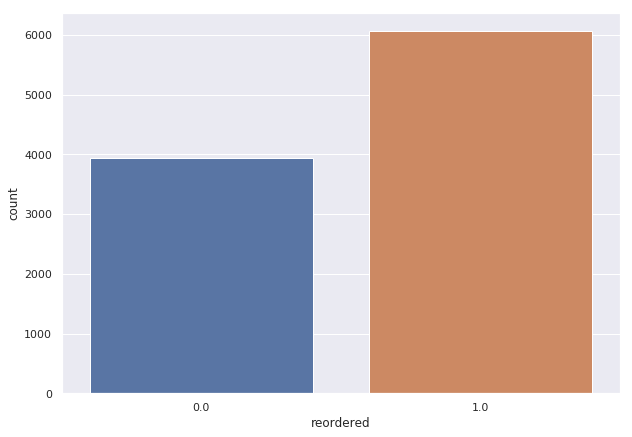

In [71]:
plt.figure(figsize=(10,7))
sns.barplot(x='reordered',y='count',data=check2)
plt.show()
plt.close()

### Which items are more often reordered?

In [164]:
query07="""WITH aggregated_prior AS (SELECT  user_id, order_id, department, aisle,product_name, order_number, add_to_cart_order, reordered,
                                          order_dow, order_hour_of_day, days_since_prior
                                          FROM order_products_prior 
                                          JOIN orders 
                                          USING (order_id) 
                                          JOIN products 
                                          USING (product_id) 
                                          JOIN departments
                                          USING (department_id)
                                          JOIN aisles
                                          USING (aisle_id)
                                          LIMIT 10000000)

SELECT p_name,AVG(count/max) 
FROM (SELECT user_id,MAX(order_number) max
     FROM orders
     GROUP BY 1) t1
JOIN (SELECT product_name p_name,user_id,Count(*) count
      FROM aggregated_prior
      GROUP BY 1,2) t2
ON  t1.user_id=t2.user_id
GROUP BY 1
ORDER BY 2 DESC"""




conn = psycopg2.connect(dbname="Instacart_market", user="postgres", password="3102", host='localhost')
check2=pd.read_sql(query07, conn)
conn.close()
          

In [165]:
check2.head(50)

,p_name,avg
0,Zero Peach Nutrient Enhanced Water Beverage,0.799603
1,Very Rare Blended Scotch Whisky,0.416088
2,Pineapple Coconut Sparkling Water,0.410065
3,Seasonal Ice Cream,0.402778
4,Loaded Cheddar Potato Bake Cups,0.400000
5,Rosemont Crest Blend Coffee,0.394037
6,Select Tender Chicken with Crisp Carrots & Lea...,0.371141
7,Organic Pear,0.364110
8,Jvle Garlic Herb Fg Chicken Breast,0.340909
9,Crunch Chocolate Caramel Pretzel Greek Yogurt,0.338833


In [80]:
query08="""WITH aggregated_prior AS (SELECT  user_id, order_id, department, aisle,product_name, order_number, add_to_cart_order, reordered,
                                     order_dow, order_hour_of_day, days_since_prior
                                     FROM order_products_prior 
                                     JOIN orders 
                                     USING (order_id) 
                                     JOIN products 
                                     USING (product_id) 
                                     JOIN departments
                                     USING (department_id)
                                     JOIN aisles
                                     USING (aisle_id))
            SELECT t.product_name,first_add,total,round(first_add/total::DECIMAL, 2) pct                     
            FROM (SELECT product_name,COUNT(*) first_add
                  FROM aggregated_prior
                  WHERE add_to_cart_order=1
                  GROUP BY 1) t
            JOIN (SELECT product_name,COUNT(*) total
                  FROM aggregated_prior
                  GROUP BY 1) r
            ON t.product_name=r.product_name
            """

conn = psycopg2.connect(dbname="Instacart_market", user="postgres", password="3102", host='localhost')
first_to_cart=pd.read_sql(query08, conn)
conn.close()

In [84]:
first_to_cart[first_to_cart['product_name']=="White Multifold Towels"]

,product_name,first_add,total,pct
7360,White Multifold Towels,662,1531,0.43


# NOTES

In [53]:
fig1=plt.figure(figsize=(15,10))
sns.violinplot(x="Month",y="Total Hourly volume", data=df2_indexed,scale="count")
fig2=plt.figure(figsize=(15,10))
fig2.add_subplot(2,2,1)
sns.violinplot(x="Month",y="NOx ug/m3_avg", data=df2_indexed,scale="count")
plt.subplot(222)


fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

ModuleNotFoundError: No module named 'twilio'

In [45]:
x = np.linspace(0, 2*np.pi, 400)
y = np.sin(x**2)

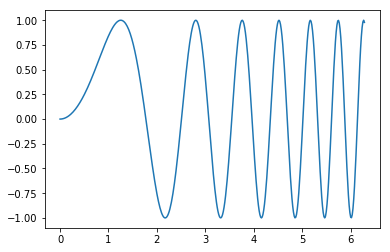

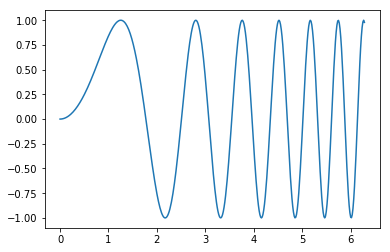

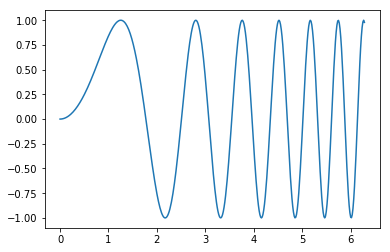

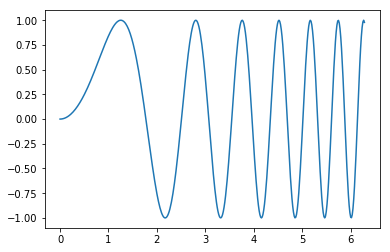

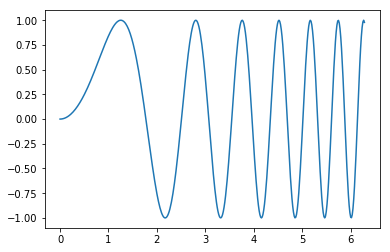

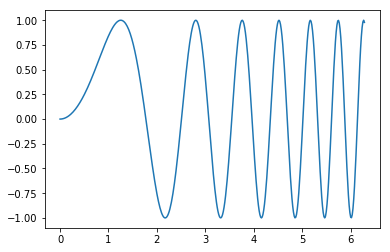

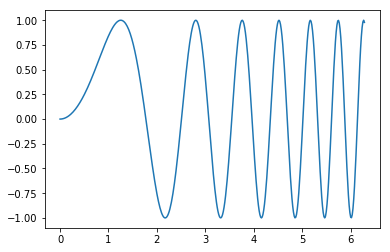

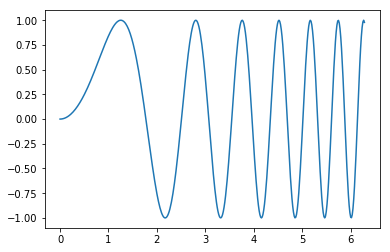

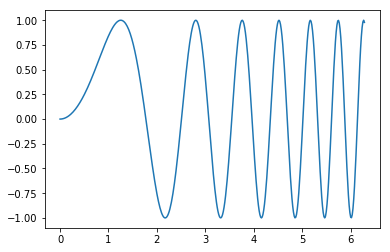

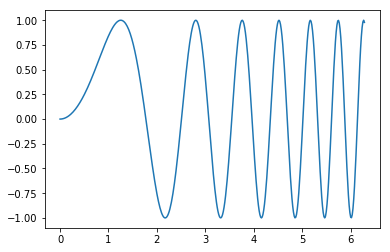

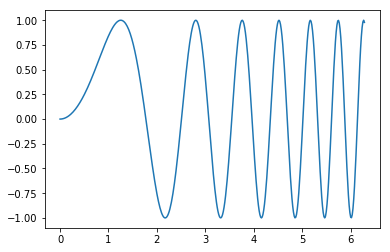

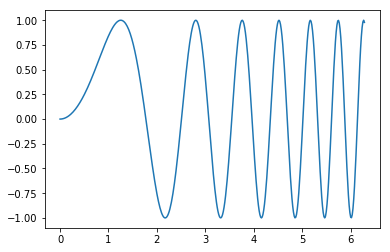

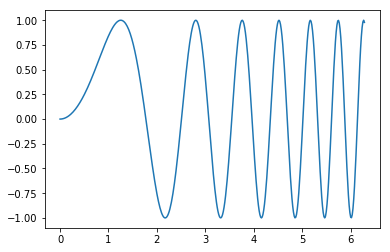

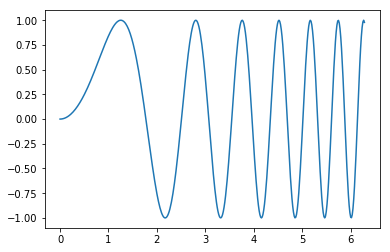

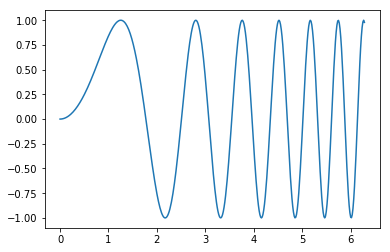

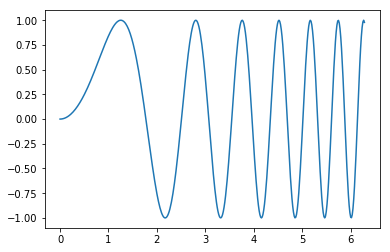

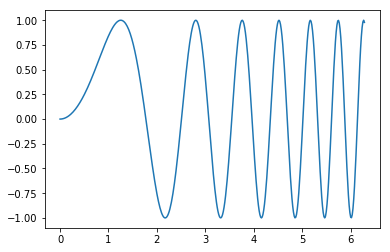

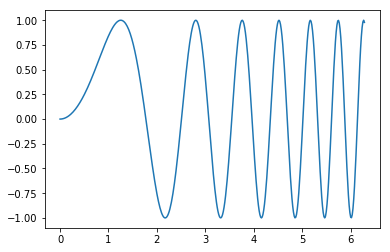

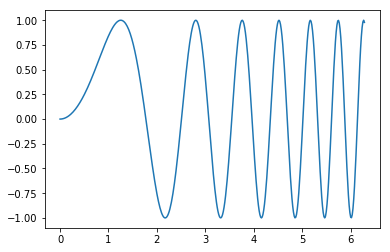

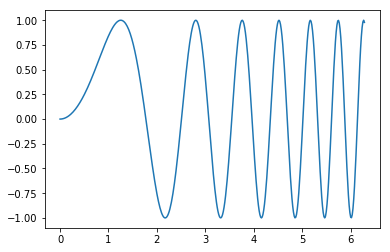

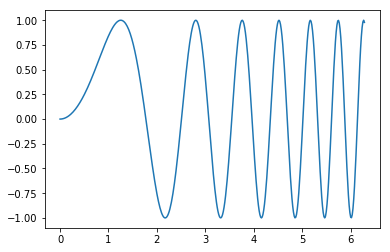

In [84]:
for i in range(21):
    plt.figure()
    plt.plot(x,y)
    plt.show()
    plt.close()

In [80]:
plt.close('all')

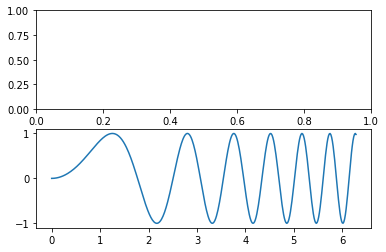

In [71]:
f, (ax1, ax2) = plt.subplots(2,1)
plt.plot(x, y)


plt.show()

In [43]:
import math

In [45]:
math.pi

3.141592653589793

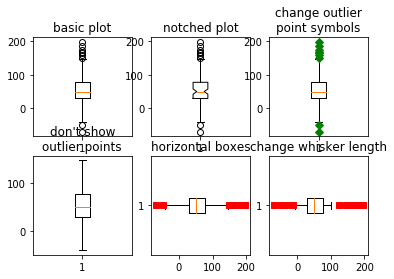

In [34]:
fig, axs = plt.subplots(2, 3)
axs[0, 0].boxplot(data)
axs[0, 0].set_title('basic plot')

# notched plot
axs[0, 1].boxplot(data, 1)
axs[0, 1].set_title('notched plot')

# change outlier point symbols
axs[0, 2].boxplot(data, 0, 'gD')
axs[0, 2].set_title('change outlier\npoint symbols')

# don't show outlier points
axs[1, 0].boxplot(data, 0, '')
axs[1, 0].set_title("don't show\noutlier points")

# horizontal boxes
axs[1, 1].boxplot(data, 0, 'rs', 0)
axs[1, 1].set_title('horizontal boxes')

axs[1, 2].boxplot(data, 0, 'rs', 0, 0.75)
axs[1, 2].set_title('change whisker length')

plt.show()

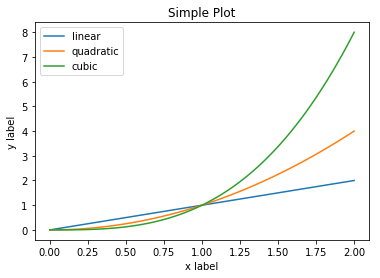

In [40]:
x = np.linspace(0, 2, 100)

plt.plot(x, x, label='linear')
plt.plot(x, x**2, label='quadratic')
plt.plot(x, x**3, label='cubic')

plt.xlabel('x label')
plt.ylabel('y label')

plt.title("Simple Plot")

plt.legend()

plt.show()